# Bollinger Bands

In [1]:
import pandas as pd
from datetime import datetime

import plotly.graph_objs as go


In [2]:
########################################################################
# Function: Alert Plotting Function

def plot_alert(df: pd.DataFrame, title: str = "", X_axis_lbl: str = "", Y_axis_lbl: str = ""):
    import matplotlib.pyplot as plt
    import matplotlib.pyplot as plt
    plt.style.use('classic')
    import numpy as np
    import pandas as pd
    
    # Sort the data Properly    
    #Option: sf.to_timestamp(sf.col("Activation Month BOP"), 'dd/MM/yyyy HH:mm:ss').alias("date"), 
    initial_df = df.sort_values(by= "date").copy()

    # Set Variables
    date = np.array(initial_df['date'])
    actuals = np.array(initial_df['actuals'])
    bar = np.array(initial_df['bar'])
    ucl = np.array(initial_df['ucl'])
    lcl = np.array(initial_df['lcl'])
    colors = np.array(initial_df['RULE_1_BEYOND_3SIGMA'].apply(lambda x: 'r' if x == 1 else 'g'))
    color_lbl = np.array(initial_df['RULE_1_BEYOND_3SIGMA'].apply(lambda x: 'SPV' if x == 1 else 'CCV'))

    # Chart Limit Sizing
    if np.min(lcl) <= np.min(actuals): 
        y_lw_lim = np.min(lcl) - np.min(lcl) * 0.1
    else:
        y_lw_lim = np.min(actuals) - np.min(actuals) * 0.1
    
    if np.max(ucl) >= np.max(actuals): 
        y_up_lim = np.max(ucl) + np.max(ucl) * 0.1
    else:
        y_up_lim = np.max(actuals) + np.max(actuals) * 0.1
    
    from matplotlib.ticker import PercentFormatter
    
    plt.clf() # Clear the space
        
    fig = plt.figure(2, figsize=[15, 10])  # an empty figure with no Axes and adjust the size
    
      # Change the size of the output!
    plt.grid(which="major", axis="y")
    plt.scatter(date, actuals, color=colors, zorder=10)  # Plot some data on the axes.
    plt.plot(date, actuals,  color="b", zorder=2,  label="Actuals")  # Plot some data on the axes.
    plt.step(
        date, ucl, where="mid", label="ucl", linestyle="--", color="r", linewidth=2
    )
    plt.plot(date, bar, color="g", linewidth=2, linestyle=":")

    plt.step(
        date, lcl, where="mid", label="lcl", linestyle="--", color="r", linewidth=2
    )
    plt.xticks(date, rotation=90)
    plt.fill_between(date, np.array(lcl, dtype=float), np.array(ucl, dtype=float), alpha=0.1, color='green', interpolate=True, step='mid')
    plt.ylim(y_lw_lim, y_up_lim)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    
    plt.xlabel(X_axis_lbl, size = 15)  # Add an x-label to the axes.
    plt.ylabel(Y_axis_lbl, size = 15)  # Add a y-label to the axes.
    plt.title(title, size = 25) # Add a title to the axes.
    plt.legend() # Add a legend.
    
    plt.show()

In [3]:
# Data Prep.
np_df = pd.read_csv("./data/bollinger_bands_data.csv", index_col=0)
np_df['date'] = pd.to_datetime(np_df['date']).dt.date
np_df.head(5)

,date,billing_counts,nonpayment_counts,np_pct
0,2023-09-01,1146,328,0.286213
1,2023-09-04,1099,332,0.302093
2,2023-09-08,1030,324,0.314563
3,2023-09-12,1126,352,0.312611
4,2023-09-16,1564,528,0.337596


In [4]:
# Bollinger Bands Data Prep.
def bollinger_bands(df, date_col, metric_col, lookback_window = 15, zscore = 2):
    # Bollinger Bands Data Calculation Function
    data_df = df.copy()
    
    data_df['actuals'] = data_df[metric_col]
    
    # Sort the dataframe by the date_col column
    data_df = data_df.sort_values(by=[date_col], ascending=True,  ignore_index=True)

    # Calculate the n-period Simple Moving Average (SMA)
    data_df['bar'] = data_df[metric_col].rolling(window=lookback_window).mean()

    # Calculate the n-period Standard Deviation (SD)
    data_df['SD'] = data_df[metric_col].rolling(window=lookback_window).std()
    
    for i in range(lookback_window - 1, 0, -1):
        # Calculate the n-period Simple Moving Average (SMA)
        data_df.loc[i, 'bar'] = data_df.loc[data_df.index[0:i], [metric_col]].mean()[0]
        
        # Calculate the n-period Standard Deviation (SD)
        data_df.loc[i, 'SD'] = data_df.loc[data_df.index[0:i], [metric_col]].std()[0]

    # Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
    data_df['ucl'] = data_df['bar'] + zscore * data_df['SD']
    data_df['lcl'] = data_df['bar'] - zscore * data_df['SD']
    
    # Rules
    data_df['RULE_1_BEYOND_3SIGMA'] =  data_df.apply(lambda x: 1 if (x['actuals'] < x['lcl']) | (x['actuals'] > x['ucl']) else 0, axis=1)
    
    return data_df

<Figure size 640x480 with 0 Axes>

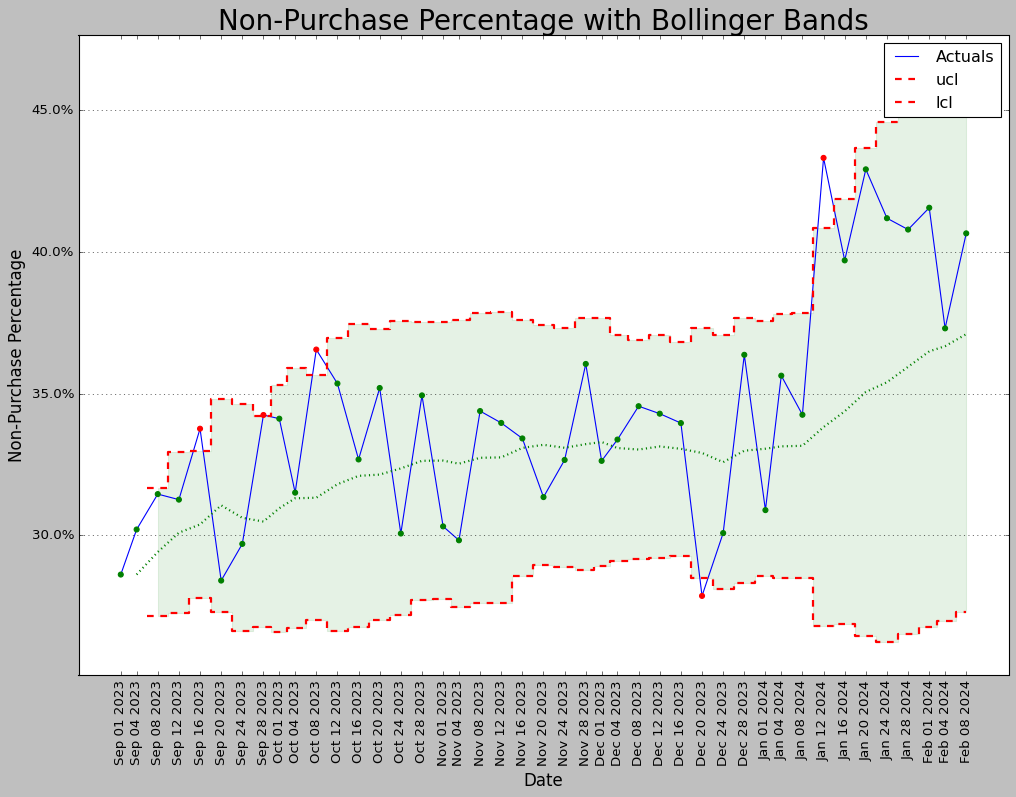

In [5]:
plot_alert(
    (bollinger_bands(np_df, 'date', 'np_pct',lookback_window = 15, zscore = 2)),
    "Non-Purchase Percentage with Bollinger Bands", 
    "Date", 
    "Non-Purchase Percentage")

# Plotly Chart Version

In [6]:
def plot_bollinger_band(df, date, metric, date_name = 'Date', metric_name = 'Metric', title = ''):
    # Bollinger Band Plotting Function.
    fig = go.Figure()

    # Add the main metric chart
    fig.add_trace(go.Scatter(x=df[date], y=df[metric], mode='lines', name=metric_name))

    # Add the Upper and Lower Bollinger Bands (UB) and shade the area
    fig.add_trace(go.Scatter(x=df[date], y=df['ucl'], mode='lines', name='Upper Bollinger Band', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=df[date], y=df['lcl'], fill='tonexty', mode='lines', name='Lower Bollinger Band', line=dict(color='green')))

    # Add Moving Average of Metic (MA)
    fig.add_trace(go.Scatter(x=df[date], y=df['bar'], mode='lines', name='Middle Bollinger Band', line=dict(color='blue')))

    # Customize the chart layout
    fig.update_layout(title=title,
                    xaxis_title=date_name,
                    yaxis_title=metric_name,
                    showlegend=True)

    # Show the chart
    fig.show()

In [7]:
plot_bollinger_band(
    bollinger_bands(np_df, 'date', 'np_pct',lookback_window = 15, zscore = 2), 
    'date', 
    'np_pct', 
    metric_name = 'Non-Payment Pct', 
    title = 'Non-Payment Pct with Bollinger Bands')